## Task 2-Predicting customer buying behaviour


### A) Explore & prepare the dataset

In [51]:
# =========================================================
# A1. Imports, data load, and basic config
# =========================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from IPython.display import display

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    roc_auc_score, average_precision_score,
    precision_recall_curve, roc_curve
)

# ---- Reproducibility & output dir ----
RANDOM_STATE = 42
FIG_DIR = Path("figures")
FIG_DIR.mkdir(exist_ok=True, parents=True)

# ---- Load dataset (official BA path) ----
candidates = [
    ("data/customer_booking.csv", "ISO-8859-1"),  # official BA path
    ("customer_booking.csv", "latin1"),           # fallback if file outside "data/"
]
df, last_err = None, None
for path, enc in candidates:
    try:
        df = pd.read_csv(path, encoding=enc, engine="python")
        print(f"Loaded file: {path} (encoding={enc})")
        break
    except Exception as e:
        last_err = e

if df is None:
    raise RuntimeError(f"Could not load dataset. Last error:\n{last_err}")

# ---- Map flight_day to numeric (1=Mon … 7=Sun) ----
if "flight_day" in df.columns and df["flight_day"].dtype == object:
    mapping = {"Mon":1,"Tue":2,"Wed":3,"Thu":4,"Fri":5,"Sat":6,"Sun":7}
    df["flight_day_raw"] = df["flight_day"]  # keep original string
    df["flight_day"] = df["flight_day"].map(mapping)
    if df["flight_day"].isna().any():
        df["flight_day"] = df["flight_day"].fillna(df["flight_day"].mode().iloc[0])

# ---- Sanity checks ----
target_col = "booking_complete"
if target_col not in df.columns:
    raise KeyError(f"Target '{target_col}' not found! Available: {list(df.columns)}")

print(f"Rows, Cols: {df.shape}")
print(f"Positive class rate ({target_col}): {df[target_col].mean():.4f}")
display(df.head(3))
df.info()

Loaded file: customer_booking.csv (encoding=latin1)
Rows, Cols: (50000, 15)
Positive class rate (booking_complete): 0.1496


,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete,flight_day_raw
0,2,Internet,RoundTrip,262,19,7,6,AKLDEL,New Zealand,1,0,0,5.52,0,Sat
1,1,Internet,RoundTrip,112,20,3,6,AKLDEL,New Zealand,0,0,0,5.52,0,Sat
2,2,Internet,RoundTrip,243,22,17,3,AKLDEL,India,1,1,0,5.52,0,Wed


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   num_passengers         50000 non-null  int64  
 1   sales_channel          50000 non-null  object 
 2   trip_type              50000 non-null  object 
 3   purchase_lead          50000 non-null  int64  
 4   length_of_stay         50000 non-null  int64  
 5   flight_hour            50000 non-null  int64  
 6   flight_day             50000 non-null  int64  
 7   route                  50000 non-null  object 
 8   booking_origin         50000 non-null  object 
 9   wants_extra_baggage    50000 non-null  int64  
 10  wants_preferred_seat   50000 non-null  int64  
 11  wants_in_flight_meals  50000 non-null  int64  
 12  flight_duration        50000 non-null  float64
 13  booking_complete       50000 non-null  int64  
 14  flight_day_raw         50000 non-null  object 
dtypes:

In [52]:
# =========================================================
# A2. Quick EDA snapshots (types, missingness, distributions)
# =========================================================

# ---- Preview first few rows ----
display(df.head(3))

# ---- Structural info ----
df.info()

# ---- Separate numeric vs categorical columns ----
num_cols_all = df.select_dtypes(include=[np.number]).columns.tolist()
cat_cols_all = [c for c in df.columns if c not in num_cols_all]

print(f"\nNumeric features: {len(num_cols_all)} | Categorical features: {len(cat_cols_all)}")

# ---- Numeric summary (count, mean, std, min, quartiles, max) ----
num_summary = df[num_cols_all].describe().T
num_summary["missing_rate"] = df[num_cols_all].isna().mean().round(4)
display(num_summary)

# ---- Categorical summary (unique values + missingness) ----
cat_summary = pd.DataFrame({
    "feature": cat_cols_all,
    "n_unique": [df[c].nunique() for c in cat_cols_all],
    "missing_rate": [df[c].isna().mean().round(4) for c in cat_cols_all]
}).sort_values("n_unique", ascending=False)
display(cat_summary)

# ---- Target distribution ----
target_counts = df["booking_complete"].value_counts(normalize=True).sort_index()
print("\nTarget distribution (booking_complete):")
print(target_counts)


,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete,flight_day_raw
0,2,Internet,RoundTrip,262,19,7,6,AKLDEL,New Zealand,1,0,0,5.52,0,Sat
1,1,Internet,RoundTrip,112,20,3,6,AKLDEL,New Zealand,0,0,0,5.52,0,Sat
2,2,Internet,RoundTrip,243,22,17,3,AKLDEL,India,1,1,0,5.52,0,Wed


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   num_passengers         50000 non-null  int64  
 1   sales_channel          50000 non-null  object 
 2   trip_type              50000 non-null  object 
 3   purchase_lead          50000 non-null  int64  
 4   length_of_stay         50000 non-null  int64  
 5   flight_hour            50000 non-null  int64  
 6   flight_day             50000 non-null  int64  
 7   route                  50000 non-null  object 
 8   booking_origin         50000 non-null  object 
 9   wants_extra_baggage    50000 non-null  int64  
 10  wants_preferred_seat   50000 non-null  int64  
 11  wants_in_flight_meals  50000 non-null  int64  
 12  flight_duration        50000 non-null  float64
 13  booking_complete       50000 non-null  int64  
 14  flight_day_raw         50000 non-null  object 
dtypes:

,count,mean,std,min,25%,50%,75%,max,missing_rate
num_passengers,50000.0,1.591240,1.020165,1.00,1.00,1.00,2.00,9.0,0.0
purchase_lead,50000.0,84.940480,90.451378,0.00,21.00,51.00,115.00,867.0,0.0
length_of_stay,50000.0,23.044560,33.887670,0.00,5.00,17.00,28.00,778.0,0.0
flight_hour,50000.0,9.066340,5.412660,0.00,5.00,9.00,13.00,23.0,0.0
flight_day,50000.0,3.814420,1.992792,1.00,2.00,4.00,5.00,7.0,0.0
wants_extra_baggage,50000.0,0.668780,0.470657,0.00,0.00,1.00,1.00,1.0,0.0
wants_preferred_seat,50000.0,0.296960,0.456923,0.00,0.00,0.00,1.00,1.0,0.0
wants_in_flight_meals,50000.0,0.427140,0.494668,0.00,0.00,0.00,1.00,1.0,0.0
flight_duration,50000.0,7.277561,1.496863,4.67,5.62,7.57,8.83,9.5,0.0
booking_complete,50000.0,0.149560,0.356643,0.00,0.00,0.00,0.00,1.0,0.0


,feature,n_unique,missing_rate
2,route,799,0.0
3,booking_origin,104,0.0
4,flight_day_raw,7,0.0
1,trip_type,3,0.0
0,sales_channel,2,0.0



Target distribution (booking_complete):
booking_complete
0    0.85044
1    0.14956
Name: proportion, dtype: float64


In [53]:
# =========================================================
# A3. Light, defensible feature engineering
# =========================================================
df_fe = df.copy()

# 1) Route: split origin and destination (robust parsing)
def split_route(val: str):
    if pd.isna(val):
        return pd.NA, pd.NA
    s = str(val)
    for sep in ["->", "-", "_", "—", " to "]:
        if sep in s:
            parts = s.split(sep)
            if len(parts) == 2:
                return parts[0].strip(), parts[1].strip()
    return s, pd.NA

if "route" in df_fe.columns:
    o, d = zip(*df_fe["route"].map(split_route))
    df_fe["origin"] = pd.Series(o, index=df_fe.index)
    df_fe["destination"] = pd.Series(d, index=df_fe.index)

# 2) Flight daypart (bin departure hour into categories)
if "flight_hour" in df_fe.columns:
    bins = [-1, 5, 11, 17, 23]
    labels = ["overnight", "morning", "afternoon", "evening"]
    df_fe["flight_daypart"] = pd.cut(df_fe["flight_hour"], bins=bins, labels=labels)

# 3) Behavioural bins: purchase lead, length of stay, duration
if "purchase_lead" in df_fe.columns:
    df_fe["lead_bin"] = pd.cut(
        df_fe["purchase_lead"],
        bins=[-1, 7, 30, 90, 365, 10_000],
        labels=["<=1w", "1w–1m", "1–3m", "3–12m", ">=12m"]
    )

if "length_of_stay" in df_fe.columns:
    df_fe["stay_bin"] = pd.cut(
        df_fe["length_of_stay"],
        bins=[-1, 3, 7, 14, 1000],
        labels=["short", "week", "fortnight", "long"]
    )

if "flight_duration" in df_fe.columns:
    df_fe["duration_bin"] = pd.cut(
        df_fe["flight_duration"],
        bins=[-0.1, 2, 5, 9, 100],
        labels=["very_short", "short", "medium", "long"]
    )

# 4) Interaction: trip type × sales channel
if {"trip_type", "sales_channel"}.issubset(df_fe.columns):
    df_fe["trip_x_channel"] = (
        df_fe["trip_type"].astype(str) + "_" + df_fe["sales_channel"].astype(str)
    )

# 5) Ancillaries count (total extras requested by customer)
for flag in ["wants_extra_baggage", "wants_preferred_seat", "wants_in_flight_meals"]:
    if flag in df_fe.columns and df_fe[flag].dtype.name == "object":
        df_fe[flag] = pd.to_numeric(df_fe[flag], errors="coerce")

if {"wants_extra_baggage", "wants_preferred_seat", "wants_in_flight_meals"}.issubset(df_fe.columns):
    df_fe["ancillaries_count"] = (
        df_fe["wants_extra_baggage"].fillna(0) +
        df_fe["wants_preferred_seat"].fillna(0) +
        df_fe["wants_in_flight_meals"].fillna(0)
    )

# 6) Route popularity (frequency encoding: how common each route is)
if "route" in df_fe.columns:
    route_freq = df_fe["route"].value_counts(dropna=False)
    df_fe["route_popularity"] = df_fe["route"].map(route_freq)

# ---- Preview engineered features ----
display(df_fe.head(3))


,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,...,flight_day_raw,origin,destination,flight_daypart,lead_bin,stay_bin,duration_bin,trip_x_channel,ancillaries_count,route_popularity
0,2,Internet,RoundTrip,262,19,7,6,AKLDEL,New Zealand,1,...,Sat,AKLDEL,<NA>,morning,3–12m,long,medium,RoundTrip_Internet,1,20
1,1,Internet,RoundTrip,112,20,3,6,AKLDEL,New Zealand,0,...,Sat,AKLDEL,<NA>,overnight,3–12m,long,medium,RoundTrip_Internet,0,20
2,2,Internet,RoundTrip,243,22,17,3,AKLDEL,India,1,...,Wed,AKLDEL,<NA>,afternoon,3–12m,long,medium,RoundTrip_Internet,2,20


In [54]:
# =========================================================
# A4. Final feature lists (drop obvious IDs if present)
# =========================================================
possible_id_like = [c for c in df_fe.columns if any(k in c.lower() for k in ["id","uuid","guid","index"])]
feature_cols = [c for c in df_fe.columns if c not in possible_id_like + [target_col]]

X = df_fe[feature_cols].copy()
y = df_fe[target_col].astype(int)

num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in X.columns if c not in num_cols]

print("n numeric:", len(num_cols), "| n categorical:", len(cat_cols))

n numeric: 11 | n categorical: 12


### B) Train a machine learning model (RandomForest)

In [55]:
# =========================================================
# B1. Preprocess (impute + scale numeric, OHE categoricals)
#     + RandomForest (balanced) in a single Pipeline
# =========================================================
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, average_precision_score

# --- Preprocessing blocks ---
numeric_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler(with_mean=False))  # safe with sparse matrices
])
categorical_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(handle_unknown="ignore", sparse=True))
])

pre = ColumnTransformer([
    ("num", numeric_pipe, num_cols),
    ("cat", categorical_pipe, cat_cols)
])

# --- Model: interpretable + robust, exposes feature_importances_ ---
rf = RandomForestClassifier(
    n_estimators=300,
    class_weight="balanced",    # handle ~15% positive rate
    random_state=RANDOM_STATE,
    n_jobs=-1
)

pipe = Pipeline([("pre", pre), ("rf", rf)])

# --- Stratified train/holdout split for honest evaluation ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=RANDOM_STATE
)
X_train.shape, X_test.shape, y_train.mean(), y_test.mean()

((40000, 23), (10000, 23), 0.14955, 0.1496)

In [56]:
# =========================================================
# B1.5. Build a SAFE pipeline for evaluation
#  - Convert categoricals to strings (replace missing with 'missing')
#  - One-hot encode categoricals (ignore unknowns)
#  - Median-impute + scale numerics (as in B1)
#  - RandomForest (same hyperparams as B1)
# =========================================================
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier

# Reuse the same num_cols / cat_cols from A4
def to_object_and_fill_missing(X):
    """
    Ensure categorical block is a DataFrame of plain Python strings,
    with missing values replaced by the token 'missing'.
    This avoids SimpleImputer + pandas extension dtype edge-cases.
    """
    X = pd.DataFrame(X)
    return X.applymap(lambda v: "missing" if pd.isna(v) else str(v))

numeric_pipe_safe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler(with_mean=False)),
])

categorical_pipe_safe = Pipeline([
    ("to_object", FunctionTransformer(to_object_and_fill_missing, validate=False)),
    ("ohe", OneHotEncoder(handle_unknown="ignore", sparse=True)),
])

pre_safe = ColumnTransformer(
    transformers=[
        ("num", numeric_pipe_safe, num_cols),
        ("cat", categorical_pipe_safe, cat_cols),
    ],
    remainder="drop",
    n_jobs=1,   # keep deterministic; avoids rare parallel edge-cases
)

rf_safe = RandomForestClassifier(
    n_estimators=300,
    class_weight="balanced",
    random_state=RANDOM_STATE,
    n_jobs=-1,
)

pipe_eval = Pipeline([
    ("pre", pre_safe),
    ("rf", rf_safe),
])

print(f"SAFE pipeline ready. Numeric={len(num_cols)} | Categorical={len(cat_cols)}")

SAFE pipeline ready. Numeric=11 | Categorical=12


In [57]:
# =========================================================
# B2. Cross-validation on training set (3-fold)
#     Metrics: ROC-AUC and PR-AUC (Average Precision)
# =========================================================
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, average_precision_score

skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)

cv_rows, cv_roc, cv_pr = [], [], []
for fold, (tr_idx, va_idx) in enumerate(skf.split(X_train, y_train), start=1):
    X_tr, X_va = X_train.iloc[tr_idx], X_train.iloc[va_idx]
    y_tr, y_va = y_train.iloc[tr_idx], y_train.iloc[va_idx]

    pipe_eval.fit(X_tr, y_tr)
    proba_va = pipe_eval.predict_proba(X_va)[:, 1]

    roc = roc_auc_score(y_va, proba_va)
    pr  = average_precision_score(y_va, proba_va)

    cv_roc.append(roc); cv_pr.append(pr)
    cv_rows.append({"fold": fold, "roc_auc": roc, "pr_auc": pr})

cv_results = pd.DataFrame(cv_rows)
print(f"CV ROC-AUC: {np.mean(cv_roc):.4f} (± {np.std(cv_roc):.4f})")
print(f"CV PR-AUC : {np.mean(cv_pr):.4f} (± {np.std(cv_pr):.4f})")
display(cv_results)

C:\DATA ANALYTICS COURSE-QUANTUM ANALYTICS\New folder\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
C:\DATA ANALYTICS COURSE-QUANTUM ANALYTICS\New folder\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
C:\DATA ANALYTICS COURSE-QUANTUM ANALYTICS\New folder\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


CV ROC-AUC: 0.7765 (± 0.0017)
CV PR-AUC : 0.3668 (± 0.0049)


,fold,roc_auc,pr_auc
0,1,0.774139,0.363394
1,2,0.777014,0.363225
2,3,0.778274,0.373697


In [58]:
# =========================================================
# B3. Fit on full training data; evaluate on holdout set
# =========================================================
from sklearn.metrics import roc_auc_score, average_precision_score

pipe_eval.fit(X_train, y_train)
proba_test = pipe_eval.predict_proba(X_test)[:, 1]

holdout_roc = roc_auc_score(y_test, proba_test)
holdout_pr  = average_precision_score(y_test, proba_test)

print(f"Holdout ROC-AUC: {holdout_roc:.4f}")
print(f"Holdout PR-AUC : {holdout_pr:.4f}")

C:\DATA ANALYTICS COURSE-QUANTUM ANALYTICS\New folder\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Holdout ROC-AUC: 0.7942
Holdout PR-AUC : 0.3918


### C. Evaluate the model

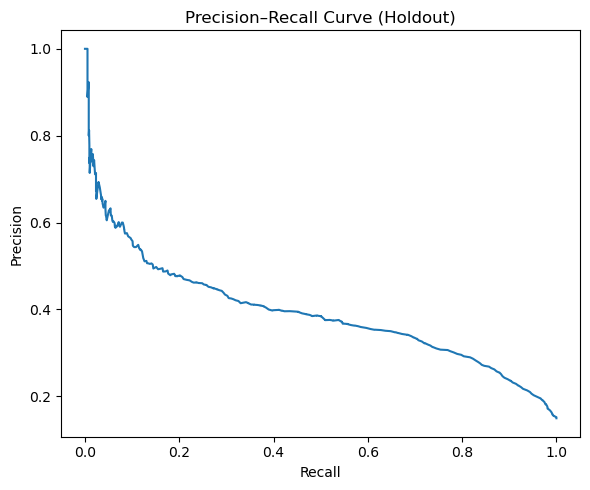

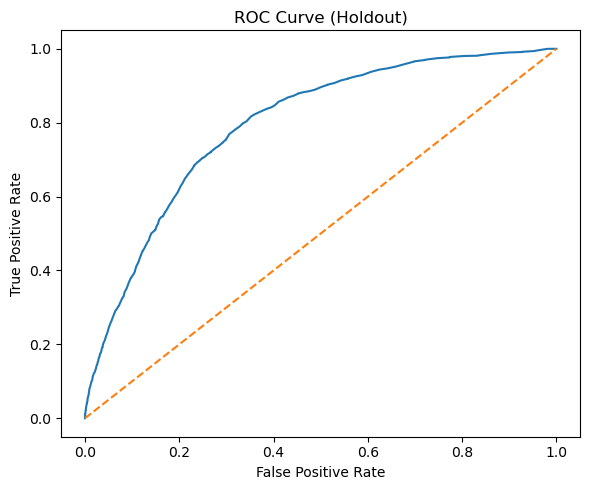

In [59]:
# =========================================================
# C1. Precision–Recall and ROC curves (Holdout)
# =========================================================
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, roc_curve
from pathlib import Path

FIG_DIR = Path("figures"); FIG_DIR.mkdir(exist_ok=True, parents=True)

# PR curve
precision, recall, _ = precision_recall_curve(y_test, proba_test)
plt.figure(figsize=(6,5))
plt.plot(recall, precision)
plt.xlabel("Recall"); plt.ylabel("Precision")
plt.title("Precision–Recall Curve (Holdout)")
plt.tight_layout(); plt.savefig(FIG_DIR / "pr_curve.png", dpi=200, bbox_inches="tight"); plt.show()

# ROC curve
fpr, tpr, _ = roc_curve(y_test, proba_test)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr); plt.plot([0,1],[0,1], linestyle="--")
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Holdout)")
plt.tight_layout(); plt.savefig(FIG_DIR / "roc_curve.png", dpi=200, bbox_inches="tight"); plt.show()

### D. Feature Importance Analysis

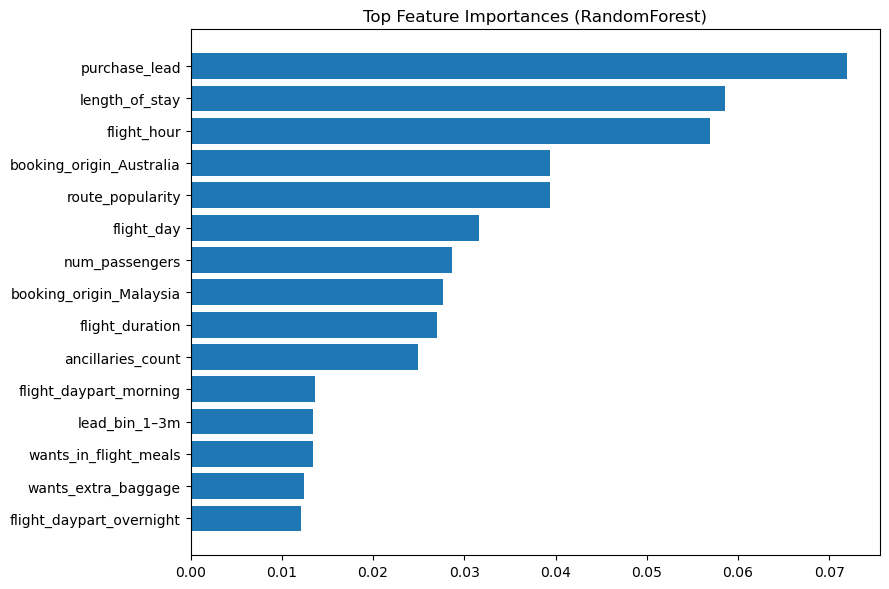

,feature,importance
1,purchase_lead,0.071953
2,length_of_stay,0.058510
3,flight_hour,0.056942
814,booking_origin_Australia,0.039346
10,route_popularity,0.039333
4,flight_day,0.031632
0,num_passengers,0.028649
860,booking_origin_Malaysia,0.027660
8,flight_duration,0.026975
9,ancillaries_count,0.024905


In [60]:
# =========================================================
# Variable contributions: top feature importances
# =========================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

pre_f = pipe_eval.named_steps["pre"]
rf_f  = pipe_eval.named_steps["rf"]

# One-hot feature names (categoricals) + numeric names
ohe = pre_f.named_transformers_["cat"].named_steps["ohe"]
cat_feature_names = ohe.get_feature_names_out(cat_cols).tolist()
feature_names = num_cols + cat_feature_names

importances = rf_f.feature_importances_
order = np.argsort(importances)[::-1]
top_k = min(15, len(importances))
top_idx = order[:top_k]

plt.figure(figsize=(9,6))
plt.barh([feature_names[i] for i in top_idx[::-1]], importances[top_idx][::-1])
plt.title("Top Feature Importances (RandomForest)")
plt.tight_layout()
plt.savefig(FIG_DIR / "feature_importances_top15.png", dpi=200, bbox_inches="tight")
plt.show()

# Export full table (great for appendix / audit)
fi_df = pd.DataFrame({"feature": feature_names, "importance": importances}) \
          .sort_values("importance", ascending=False)
fi_df.to_csv(FIG_DIR / "feature_importances.csv", index=False)
display(fi_df.head(10))

In [61]:
# =========================================================
# C3. Precision@k and Lift@k (5%, 10%, 20%) on HOLDOUT
# =========================================================
import numpy as np
import pandas as pd

def precision_at_k(y_true, y_scores, k=0.10):
    n = max(1, int(np.ceil(len(y_scores) * k)))
    idx = np.argsort(y_scores)[::-1][:n]
    return float(y_true.iloc[idx].mean())

def lift_at_k(y_true, y_scores, k=0.10):
    base = float(y_true.mean())
    p_at_k = precision_at_k(y_true, y_scores, k)
    return (p_at_k / base) if base > 0 else np.nan

rows = []
for k in [0.05, 0.10, 0.20]:
    rows.append({
        "k": f"{int(k*100)}%",
        "contacts": int(np.ceil(len(y_test) * k)),
        "precision@k": round(precision_at_k(y_test, proba_test, k), 4),
        "lift@k": round(lift_at_k(y_test, proba_test, k), 2),
        "baseline_rate": round(float(y_test.mean()), 4),
    })

k_table = pd.DataFrame(rows)
display(k_table)

,k,contacts,precision@k,lift@k,baseline_rate
0,5%,500,0.4920,3.29,0.1496
1,10%,1000,0.4380,2.93,0.1496
2,20%,2000,0.3795,2.54,0.1496


In [62]:
# An operating threshold + a mini confusion matrix at top-10%

import numpy as np
from sklearn.metrics import confusion_matrix, precision_score, recall_score

k = 0.10
n = int(np.ceil(len(proba_test) * k))
thr = np.sort(proba_test)[::-1][n-1]   # score threshold at top-k

y_pred_topk = (proba_test >= thr).astype(int)

cm = confusion_matrix(y_test, y_pred_topk)
prec = precision_score(y_test, y_pred_topk)
rec  = recall_score(y_test, y_pred_topk)

print(f"Top {int(k*100)}% threshold = {thr:.4f}")
print("Confusion matrix [[TN, FP], [FN, TP]]:\n", cm)
print(f"Precision@{int(k*100)}% = {prec:.4f}")
print(f"Recall@{int(k*100)}%    = {rec:.4f}")

Top 10% threshold = 0.3600
Confusion matrix [[TN, FP], [FN, TP]]:
 [[7940  564]
 [1056  440]]
Precision@10% = 0.4382
Recall@10%    = 0.2941
